# Test suite for a Neural Network to predict the rest-eigen part from the eigenvalues and the eigen-eigen part

In [1]:
using LmaPredict, Flux, Statistics, ProgressMeter, Plots, Random, StatsBase

## Reading the data

In [2]:
const path_config = "/Users/lukasgeyer/Studium/Computational Sciences/Masterarbeit/Daten Simon/dat"
const path_plot = "../plots"

"../plots"

In [4]:
fname = readdir(path_config)[2:5001]
idx = sortperm( parse.(Int64, fname))
fname = fname[idx]
em_n = "PA"

cnfgarr = Vector{LMAConfig}(undef, 0)
for f in fname
    push!(cnfgarr, get_LMAConfig(joinpath(path_config, f), "g5-g5", em=em_n, bc=false))
end

## Splitting data in training and test sets

In [5]:
NCNFG = length(cnfgarr)
train_size = 500
test_size = NCNFG - train_size

TSRC = "24"
TVALS = length(cnfgarr[1].data["rr"][TSRC]) - 1
if em_n == "PA"
    EIGVALS = 32
else 
    EIGVALS = 64
end

eigvals_data_train = Array{Float64}(undef, EIGVALS, train_size)
rr_data_train = Array{Float64}(undef, TVALS, train_size)
ee_data_train = Array{Float64}(undef, TVALS, train_size)
re_data_train = Array{Float64}(undef, TVALS, train_size)

eigvals_data_test = Array{Float64}(undef, EIGVALS, test_size)
rr_data_test = Array{Float64}(undef, TVALS, test_size)
ee_data_test = Array{Float64}(undef, TVALS, test_size)
re_data_test = Array{Float64}(undef, TVALS, test_size)

for (k, dd) in enumerate(getfield.(cnfgarr, :data)[1:train_size])
    eigvals_data_train[:,k] = copy(cnfgarr[k].data["eigvals"][1:EIGVALS])
    rr_data_train[:,k] = getindex(getindex(dd, "rr"), TSRC)[2:end]
    ee_data_train[:,k] = getindex(getindex(dd, "ee"), TSRC)[2:end]
    re_data_train[:,k] = getindex(getindex(dd, "re"), TSRC)[2:end]
end
for (k, dd) in enumerate(getfield.(cnfgarr, :data)[train_size+1:NCNFG])
    eigvals_data_test[:,k] = copy(cnfgarr[k].data["eigvals"][1:EIGVALS])
    rr_data_test[:,k] = getindex(getindex(dd, "rr"), TSRC)[2:end]
    ee_data_test[:,k] = getindex(getindex(dd, "ee"), TSRC)[2:end]
    re_data_test[:,k] = getindex(getindex(dd, "re"), TSRC)[2:end]
end

## Defining training and test data

We construct a Neural Network that has two inputs: the $n_{\lambda}$ inversed eigenvalues $\{\lambda_i\}$ and the $n_{ee}$ eigen-eigen-contributions $\{ee_i\}$. Each input is handled seperately by two dense layers of size **hidden_length** followed by one fully connected layer of the same size as the input (so $n_{\lambda}$ or $n_{ee}$). These two vectors then get combined via vcat and then fed into three dense layers of again size **hidden_length**, followed by an output layer which has the same size as the rest-eigen contributions (so 47).

$ v_{i,1} = \begin{bmatrix} \ \frac{1}{\lambda_1} \ \\[6pt] \ \frac{1}{\lambda_2} \ \\[6pt] \ \frac{1}{\lambda_3} \ \\[6pt] \vdots \\[6pt] \frac{1}{\lambda_{n_{\lambda}}} \end{bmatrix} , \ \ \ 
 v_{i,2} = \begin{bmatrix} \ ee_1 \ \\[6pt] \ ee_2 \ \\[6pt]\ ee_3 \ \\[6pt] \vdots \\[6pt]\ ee_{n_{ee}} \ \end{bmatrix}
$

In [6]:
input_length = TVALS + EIGVALS
output_length = TVALS
hidden_length = 2*input_length

input_shape_train_ee = ee_data_train
input_shape_train_ev = 1 ./ eigvals_data_train
output_shape_train = re_data_train

input_shape_test_ee = ee_data_test
input_shape_test_ev = 1 ./ eigvals_data_test
output_shape_test = re_data_test;

### Input data, normalized and standardized

In [7]:
max_input_train_ee = maximum(input_shape_train_ee)
max_input_train_ev = maximum(input_shape_train_ev)

min_input_train_ee = minimum(input_shape_train_ee)
min_input_train_ev = minimum(input_shape_train_ev)

mean_input_train_ee = mean(mean.([input_shape_train_ee[:,i] for i in 1:train_size]))
mean_input_train_ev = mean(mean.([input_shape_train_ev[:,i] for i in 1:train_size]))

std_input_train_ee = std(mean.([input_shape_train_ee[:,i] for i in 1:train_size]))
std_input_train_ev = std(mean.([input_shape_train_ev[:,i] for i in 1:train_size]))

input_data_train_ee_normalized = (input_shape_train_ee .- max_input_train_ee) ./ (max_input_train_ee - min_input_train_ee)
input_data_train_ev_normalized = (input_shape_train_ev .- max_input_train_ev) ./ (max_input_train_ev - min_input_train_ev)
input_data_train_normalized = (input_data_train_ev_normalized, input_data_train_ee_normalized)

input_data_train_ee_standardized = (input_shape_train_ee .- mean_input_train_ee) ./ std_input_train_ee
input_data_train_ev_standardized = (input_shape_train_ev .- mean_input_train_ev) ./ std_input_train_ev
input_data_train_standardized = (input_data_train_ev_standardized, input_data_train_ee_standardized)

input_data_test_ee_normalized = (input_shape_test_ee .- max_input_train_ee) ./ (max_input_train_ee - min_input_train_ee)
input_data_test_ev_normalized = (input_shape_test_ev .- max_input_train_ev) ./ (max_input_train_ev - min_input_train_ev)
input_data_test_normalized = (input_data_test_ev_normalized, input_data_test_ee_normalized)

input_data_test_ee_standardized = (input_shape_test_ee .- mean_input_train_ee) ./ std_input_train_ee
input_data_test_ev_standardized = (input_shape_test_ev .- mean_input_train_ev) ./ std_input_train_ev
input_data_test_standardized = (input_data_test_ev_standardized, input_data_test_ee_standardized);

### Output data, normalized and standardized

In [9]:
max_output_train = maximum(output_shape_train)
min_output_train = minimum(output_shape_train)

mean_output_train = mean(mean.([output_shape_train[:,i] for i in 1:train_size]))
std_output_train = std(mean.([output_shape_train[:,i] for i in 1:train_size]))

output_data_train_normalized = (output_shape_train .- max_output_train) ./ (max_output_train - min_output_train)
output_data_train_standardized = (output_shape_train .- mean_output_train) ./ std_output_train;

## Defining the Network

In [10]:
struct Join{T, F}
  combine::F
  paths::T
end

Join(combine, paths...) = Join(combine, paths)
(m::Join)(xs::Tuple) = m.combine(map((f, x) -> f(x), m.paths, xs)...)
(m::Join)(xs...) = m(xs)

In [18]:
model_eigvals = Chain(
    Dense(EIGVALS => hidden_length, tanh),
    Dense(hidden_length => hidden_length, tanh),
    Dense(hidden_length => EIGVALS, tanh)
    ) |> f64

model_tvals = Chain(
    Dense(TVALS => hidden_length, tanh),
    Dense(hidden_length => hidden_length, tanh),
    Dense(hidden_length => TVALS, tanh)
    ) |> f64

model_combined = Chain(
    Join(vcat,
        model_eigvals,
        model_tvals
        ),
    Dense(input_length => hidden_length, tanh),
    Dense(hidden_length => hidden_length, tanh),
    Dense(hidden_length => hidden_length, tanh),
    Dense(hidden_length => output_length, NNlib.tanhshrink),
) |> f64

Chain(
  Join{Tuple{Chain{Tuple{Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}, Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}, Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}}}, Chain{Tuple{Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}, Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}, Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}}}}, typeof(vcat)}(vcat, (Chain(Dense(32 => 158, tanh), Dense(158 => 158, tanh), Dense(158 => 32, tanh)), Chain(Dense(47 => 158, tanh), Dense(158 => 158, tanh), Dense(158 => 47, tanh)))),
  Dense(79 => 158, tanh),               # 12_640 parameters
  Dense(158 => 158, tanh),              # 25_122 parameters
  Dense(158 => 158, tanh),              # 25_122 parameters
  Dense(158 => 47, tanhshrink),         # 7_473 parameters
)                   # Total: 8 arrays, 70_357 parameters, 1.115 MiB.

### Defining loader, optimizer and loss function

In [19]:
loader = Flux.DataLoader((input_data_train_normalized, output_data_train_normalized), batchsize=32, shuffle=true)

optim = Flux.setup(Flux.Adam(0.01), model_combined)

function loss(flux_model, x, y)
    ŷ = flux_model(x)
    Flux.mse(ŷ, y, agg=sum)
end

loss (generic function with 1 method)

## Training the Network

The network sees the whole data set **epochs** times. As loss function we use Mean Squared Error.

In [20]:
epochs = 10_000

losses = []
@showprogress for epoch in 1:epochs
    for (x, y) in loader
        grads = gradient(m -> loss(m, x, y), model_combined)
        Flux.update!(optim, model_combined, grads[1])
        push!(losses,loss(model_combined, x, y))
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:04:20


## Checking loss dynamics during training

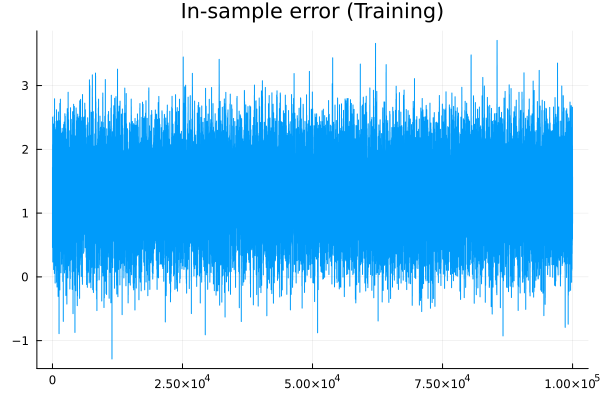

In [21]:
plot(log.(losses[end-100000:end] .- minimum(losses)), title="In-sample error (Training)", legend=:false)

## Checking out-of-sample results

maximum error: 2.9682574877415787e-6
minimum error: 3.4952495561242123e-7
average error: 9.366137416840687e-7


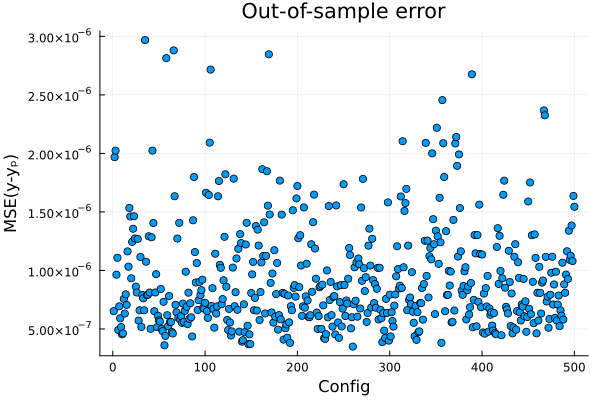

In [22]:
out_of_sample_predictions = (model_combined(input_data_test_normalized) .* (max_output_train - min_output_train)) .+ max_output_train
out_of_sample_error = [Flux.mse(out_of_sample_predictions[:,i], output_shape_test[:,i]) for i in 1:train_size]

println("maximum error: ", maximum(out_of_sample_error))
println("minimum error: ", minimum(out_of_sample_error))
println("average error: ", mean(out_of_sample_error))

scatter(out_of_sample_error, title="Out-of-sample error", legend=:false)
xlabel!("Config")
ylabel!("MSE(y-yₚ)")

In [24]:
l = @layout [a b c; d e f; g h i]

c1 = rand([i for i in 1:500])
p1 = scatter(output_shape_test[:,c1], label="Actual")
scatter!(p1, out_of_sample_predictions[:,c1], label="Prediction", legend=:top)

c2 = rand([i for i in 1:500])
p2 = scatter(output_shape_test[:,c2], label="Actual")
scatter!(p2, out_of_sample_predictions[:,c2], label="Prediction", legend=:top)

c3 = rand([i for i in 1:500])
p3 = scatter(output_shape_test[:,c3], label="Actual")
scatter!(p3, out_of_sample_predictions[:,c3], label="Prediction", legend=:top, )

c4 = rand([i for i in 1:500])
p4 = scatter(output_shape_test[:,c4], label="Actual")
scatter!(p4, out_of_sample_predictions[:,c4], label="Prediction", legend=:top)

c5 = rand([i for i in 1:500])
p5 = scatter(output_shape_test[:,c5], label="Actual")
scatter!(p5, out_of_sample_predictions[:,c5], label="Prediction", legend=:top)

c6 = rand([i for i in 1:500])
p6 = scatter(output_shape_test[:,c6], label="Actual")
scatter!(p6, out_of_sample_predictions[:,c6], label="Prediction", legend=:top)

c7 = rand([i for i in 1:500])
p7 = scatter(output_shape_test[:,c7], label="Actual")
scatter!(p7, out_of_sample_predictions[:,c7], label="Prediction", legend=:top)

c8 = rand([i for i in 1:500])
p8 = scatter(output_shape_test[:,c8], label="Actual")
scatter!(p8, out_of_sample_predictions[:,c8], label="Prediction", legend=:top)

c9 = rand([i for i in 1:500])
p9 = scatter(output_shape_test[:,c9], label="Actual")
scatter!(p9, out_of_sample_predictions[:,c9], label="Prediction", legend=:top)

plot(p1, p2, p3, p4, p5, p6, p7, p8, p9, layout = l, size=(1200,1000), dpi=1000, markerstrokewidth = 0)
#savefig(joinpath(path_plot, "neural_network_test.pdf"))

## Bias correction

### Applying bias correction on a percentage of the test data

In [40]:
percentage = 0.1

n_configs = Int(test_size * percentage)

configs = sort!(sample([i for i in 1:test_size], n_configs, replace = false))

uncorr_target_configs = stack(deleteat!([output_shape_test[:,i] for i in 1:test_size],configs), dims=2)

mean_target = mean.([uncorr_target_configs[i,:] for i in 1:TVALS])
σ_mean_target = std.([uncorr_target_configs[i,:] for i in 1:TVALS]) ./ sqrt(test_size - 1 - n_configs)
    
mean_predicted = mean.([out_of_sample_predictions[i,:] for i in 1:TVALS])
σ_predicted = std.([out_of_sample_predictions[i,:] for i in 1:TVALS]) ./ sqrt(test_size - 1 - n_configs)
        
bias_correction = mean(hcat([[out_of_sample_predictions[:,i] - output_shape_test[:,i] for i in configs][i] for i in 1:length(configs)]...), dims=2)
σ_bc = std(hcat([[out_of_sample_predictions[:,i] - output_shape_test[:,i] for i in configs][i] for i in 1:length(configs)]...), dims=2) ./ sqrt(n_configs - 1)

mean_predicted = mean_predicted - bias_correction
σ_pred_bc = σ_predicted + σ_bc

mean_diff = (mean_target .- mean_predicted) ./ mean_target
σ_diff = sqrt.(sum.(hcat([((mean_target .- out_of_sample_predictions[:,i] - bias_correction) ./ mean_target).^2 for i in 1:test_size]...)[k,:] for k in 1:TVALS) ./ (test_size - 1));

In [45]:
p = scatter(
    size=(1400,1000),
    dpi = 1000,
    thickness_scaling = 1.6,
    title="bc: $n_configs"
)
    
scatter!(p,
    mean_target[7:41],
    yerr=σ_mean_target[7:41],
    label="actual",
    legend=:bottom,
    linecolor=:blue,
    marker=:xcross,
    markersize = 2,
    markerstrokewidth = 0.3
)

scatter!(p,
    mean_predicted[7:41],
    yerr=σ_pred_bc[7:41],
    label="predicted",
    legend=:bottom,
    linecolor=:red,
    marker =:+,
    markersize = 2,
    markerstrokewidth = 0.3
)